# Application of inferential statistics to data analysis

In the exploratory data it was discovered that there are several types of listings (entire homes, private and shared rooms). By looking at the graphical representation of prices for each of these types(please see image below), the difference in medians was noticeable. 

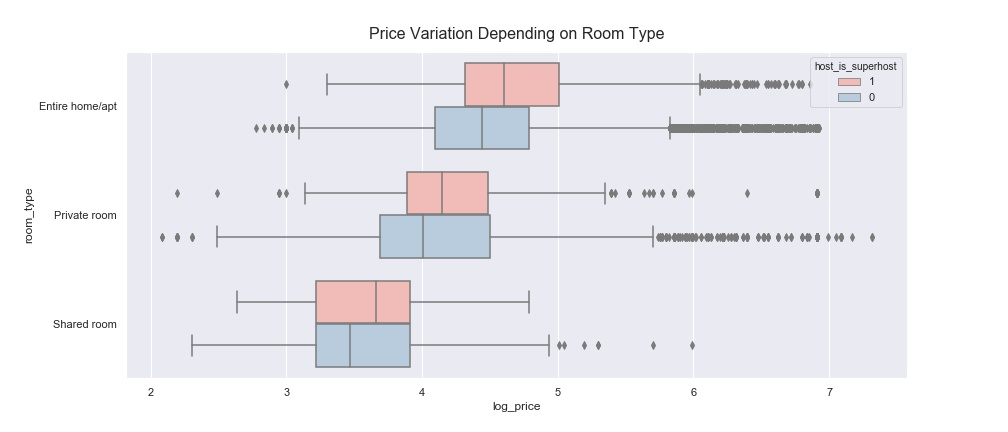

In [1]:
from IPython.display import Image
Image(filename='price_by_room_type.jpg')

Also the vast majority of the listings (86%) are entire home listings. Given these two findings, I decided to drop private and shared room listings and only focus further analysis on entire apartments. Maybe in reality there is no actual difference and the observed data was just a random outcome. To see if my decision to drop 14% of data was correct, I will perform below hypothesis testing:

$H_0$: Average price of entire home is the same as average price for private and/or shared rooms

$H_1$: Average prices are different

In [2]:
# import packages
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# load data 
df = pd.read_csv('listings_cleaned.csv')

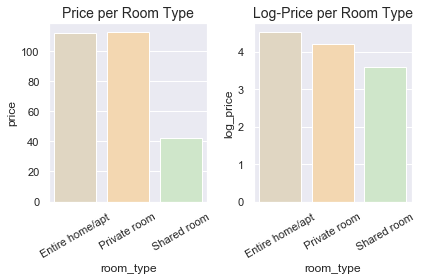

In [4]:
# visual first
room = df.groupby('room_type').mean().loc[:, ['price', 'log_price']].reset_index()
plt.subplot(1,2,1)
sns.barplot(x='room_type', y='price', data = room, palette='Pastel1_r', ci=0)
plt.title('Price per Room Type', size = 14)
plt.xticks(rotation=30)

plt.subplot(1,2,2)
sns.barplot(x='room_type', y='log_price', data = room, palette='Pastel1_r', ci=0)
plt.title('Log-Price per Room Type', size = 14)
plt.xticks(rotation=30)

plt.tight_layout()
plt.savefig("average_price_by_room_type.jpg")
plt.show()

It looks like the price for shared rooms is different from the other two. Interestingly the average prices for entire apartments and private rooms are not much different on the graph. Log-prices show more visual difference. Relatively high average for private rooms can be attributed to luxury and boutique hotel listings that are listed as private rooms. Also at the data cleaning step the algorithm used to test for outliers cut out entire home listings with prices over approximately $\$$1000. For private rooms the upper limit happened to be higher as large percent of these listings were higher end rooms in fancy hotels.

For testing I will use built-in function ttest_ind in pachage stats. First I will calculate t-value for 95% confidence level to compare calculated ststistics to. If calculated t-statistic will be smaller than the t-value from t-distribution, than H0 cannot be rejected.

In [5]:
# create separate arrays for each room category
ent_home =df[df.room_type=='Entire home/apt'].price
private = df[df.room_type=='Private room'].price
shared = df[df.room_type=='Shared room'].price

In [6]:
# calculate t-value for comparison
stats.t.ppf(0.95, len(ent_home)+len(private)-2)

1.6448791378741838

I will look at entire home and private room listings first.

In [7]:
# calculate test statistics and p-value assuming different variances for different room types.
stats.ttest_ind(private,ent_home,equal_var=False)

Ttest_indResult(statistic=0.41682454825588433, pvalue=0.6768176088208591)

T-statustics is a lot smaller and p-value is relatively large. That means that with over 67% null hypothesis cannot be rejected and average listing prices for entire apartments and private rooms are close.

Let's compare shared room listing prices to the ones for entire homes and private rooms.

In [8]:
# test against entire home
stats.ttest_ind(ent_home,shared,equal_var=False)

Ttest_indResult(statistic=43.66824606486336, pvalue=2.1163862735311154e-176)

In [9]:
# test against private rooms
stats.ttest_ind(private,shared,equal_var=False)

Ttest_indResult(statistic=26.04076937297973, pvalue=1.1034486322629737e-136)

In both cases t-statistic is much larger than our test value of 1.645 and p-values are really small, therefore null hypothesis can be rejected and shared room average prices differ from the ones for entire homes and private rooms.

But are the prices for entire apartments and private rooms in fact so similar? Let's see distribution of prices on histogram. I will compare normed histograms to keep the scale.

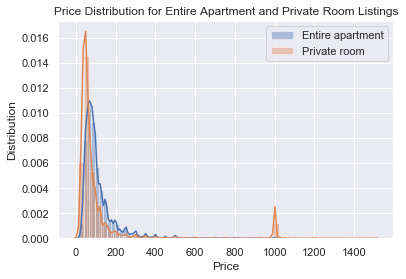

In [10]:
# plot histagram of prices to compare
sns.distplot(ent_home, bins = 50, hist = True, label = 'Entire apartment')
sns.distplot(private, bins = 50, hist = True, label = 'Private room')
plt.xlabel("Price")
plt.ylabel("Distribution")
plt.legend()
plt.title("Price Distribution for Entire Apartment and Private Room Listings")
plt.savefig("price_distribution.jpg")
plt.show()

The shapes of distributions look similar, but entire home listings seem to have overall more higher prices. The distribution peaks are different. The private room category has however some listings priced around $\$$1000 and not that many listings over $\$$200. As noted above these listings represent rooms in luxury boutique hotels and represent completely different experiences than other listings in this category.

Since there are large outliers in private room category, they may throw out the results. It makes more sence to compare  medians in this case. It will be done using bootstrap technique with permutations. The null hypothesis will be as follows in this case.

$H_0$: median prices for entire home and private room listings are the same

First lets do graphical EDA.

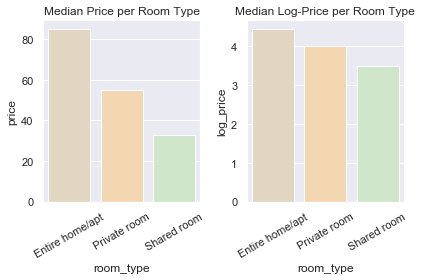

In [11]:
# visual first
room = df.groupby('room_type').median().loc[:, ['price', 'log_price']].reset_index()
plt.subplot(1,2,1)
sns.barplot(x='room_type', y='price', data = room, palette='Pastel1_r', ci=0)
plt.title('Median Price per Room Type', size = 12)
plt.xticks(rotation=30)

plt.subplot(1,2,2)
sns.barplot(x='room_type', y='log_price', data = room, palette='Pastel1_r', ci=0)
plt.title('Median Log-Price per Room Type', size = 12)
plt.xticks(rotation=30)

plt.tight_layout()
plt.savefig("median_price_by_room_type.jpg")
plt.show()

The diffirence in median prices is more visual. Let's now test if it in fact true.

In [12]:
# calculate bootstrap of median differences
N_rep = 10000
bs_diff = np.empty(N_rep)
ent_home =df[df.room_type=='Entire home/apt'].price
private = df[df.room_type=='Private room'].price
x = np.concatenate([ent_home, private])
for i in range(N_rep):
    sample = np.random.permutation(x) # rearrange all prices randomly
    #divide in two groups and calculate medians
    med_ent = np.median(sample[:len(ent_home)]) 
    med_private = np.median(sample[len(ent_home):])
    bs_diff[i] = med_ent - med_private
    
# calculate actually observed value
obs_med_diff = ent_home.median() - private.median()



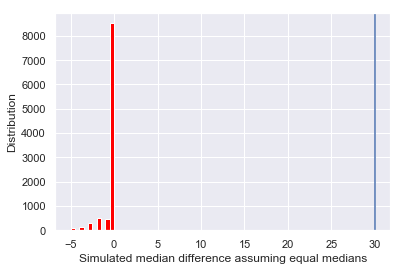

In [13]:
# plot histogram and actual value
plt.hist(bs_diff, bins = 10, color='red')
plt.axvline(obs_med_diff)
plt.xlabel('Simulated median difference assuming equal medians')
plt.ylabel('Distribution')
plt.savefig("simulated_median_difference.jpg")
plt.show()

Even from the plot we see that there are almost (if not none) values as extreme as the observed value. But I will calculate p-value (probability of getting the value at least as large as observed) to confirm the result.

In [14]:
# calculate p-value
p = np.sum(bs_diff >= obs_med_diff)/len(bs_diff)
if p >= 0.05:
    print ('p-value =', p, ' and p-value >= 0.05. Null hypothesis cannot be rejected.')
else:
    print('p-value =', p, ' and p-value < 0.05. Null hypothesis should be rejected.')

p-value = 0.0  and p-value < 0.05. Null hypothesis should be rejected.


Thus we see that median prices in fact differ for entire apartment and private room listings. This supports my decision to analyse various room types separately. 